Text Analysis and Natural Language Processing, Summer 2024

Assignment 1

Jeremy Glasgow

Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

nltk.download("stopwords")
nltk.download("punkt")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

**1. Data Acquisition**

Load dataset and save to dataframe

In [2]:
from google.colab import drive
drive.mount('/content/drive')
pathToCsv = '/content/drive/MyDrive/complaints-cfpb-1.csv'
data = pd.read_csv(pathToCsv)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**2. Exploratory Data Analysis**

View first few rows

In [3]:
data.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,4/27/2024,Credit reporting or other personal consumer re...,Credit reporting,Improper use of your report,Credit inquiries on your report that you don't...,I am requesting the removal of fraudulent inqu...,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",PA,19119,NaN,Consent provided,Web,4/27/2024,Closed with explanation,Yes,NaN,8875532
1,3/26/2024,Credit reporting or other personal consumer re...,Credit reporting,Incorrect information on your report,Information belongs to someone else,I am writing to delete the following informati...,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",TX,75052,NaN,Consent provided,Web,3/26/2024,Closed with non-monetary relief,Yes,NaN,8629551
2,3/26/2024,Credit reporting or other personal consumer re...,Credit reporting,Problem with a company's investigation into an...,Investigation took more than 30 days,I am disappointed to have received a credit re...,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",NY,11364,NaN,Consent provided,Web,3/26/2024,Closed with non-monetary relief,Yes,NaN,8630686
3,3/26/2024,Credit reporting or other personal consumer re...,Credit reporting,Problem with a company's investigation into an...,Their investigation did not fix an error on yo...,I have received my credit report which suggest...,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",NJ,07201,NaN,Consent provided,Web,3/26/2024,Closed with non-monetary relief,Yes,NaN,8626965
4,3/26/2024,Credit reporting or other personal consumer re...,Credit reporting,Improper use of your report,Reporting company used your report improperly,In accordance with the Fair Credit Reporting a...,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",AZ,85031,NaN,Consent provided,Web,3/26/2024,Closed with non-monetary relief,Yes,NaN,8631352


Complaints by product

<Axes: xlabel='counts', ylabel='Product'>

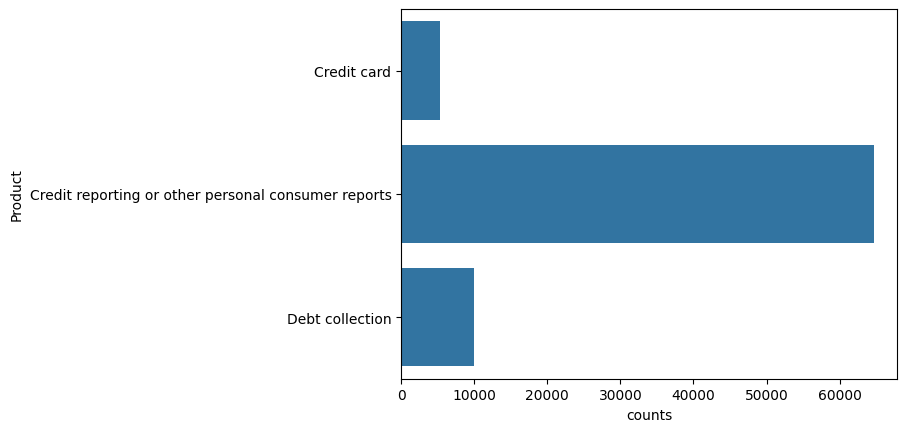

In [4]:
productCounts = data.groupby(['Product']).size().reset_index(name='counts')
productCounts.sort_values(by='counts', ascending=False)
sns.barplot(y='Product', x='counts', data=productCounts)

Complaints by issue type

<Axes: xlabel='counts', ylabel='Issue'>

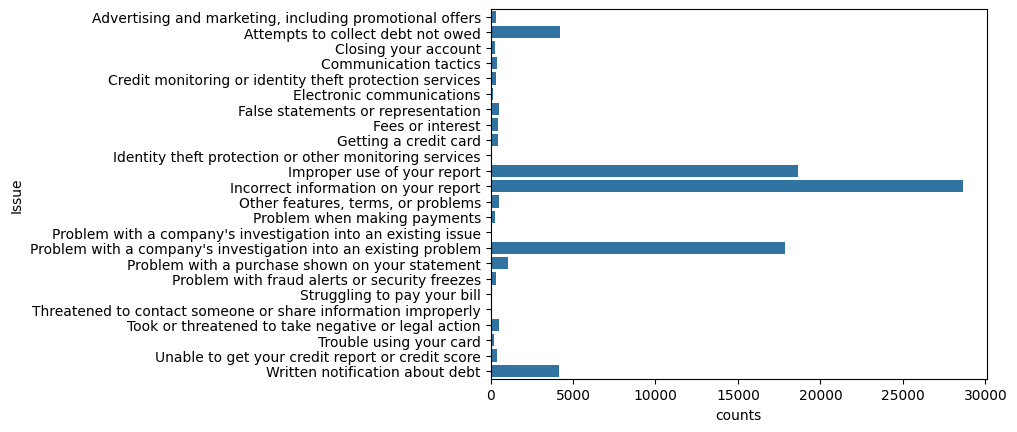

In [5]:
issueCounts = data.groupby(['Issue']).size().reset_index(name='counts')
issueCounts.sort_values(by='counts', ascending=False)
sns.barplot(y='Issue', x='counts', data=issueCounts)

Length of complaint by product

<Axes: xlabel='Complaint Length', ylabel='Product'>

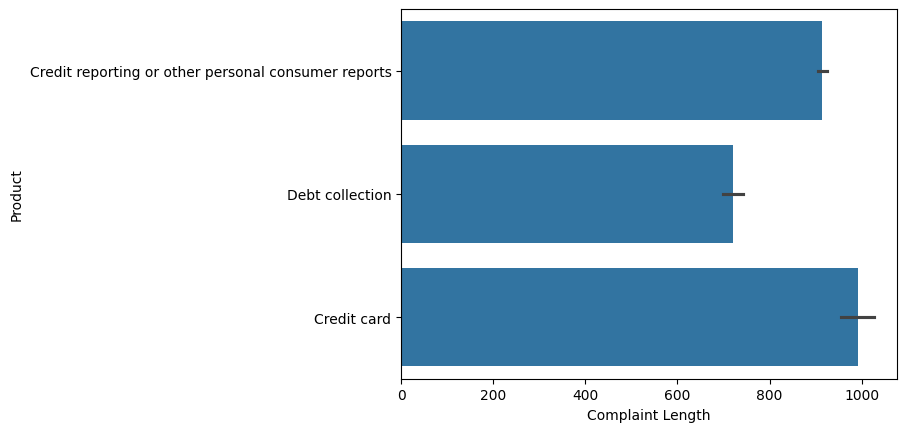

In [6]:
data["Complaint Length"] = data["Consumer complaint narrative"].str.len()
sns.barplot(x='Complaint Length', y='Product', data=data)

Length of complaint by issue type

<Axes: xlabel='Complaint Length', ylabel='Issue'>

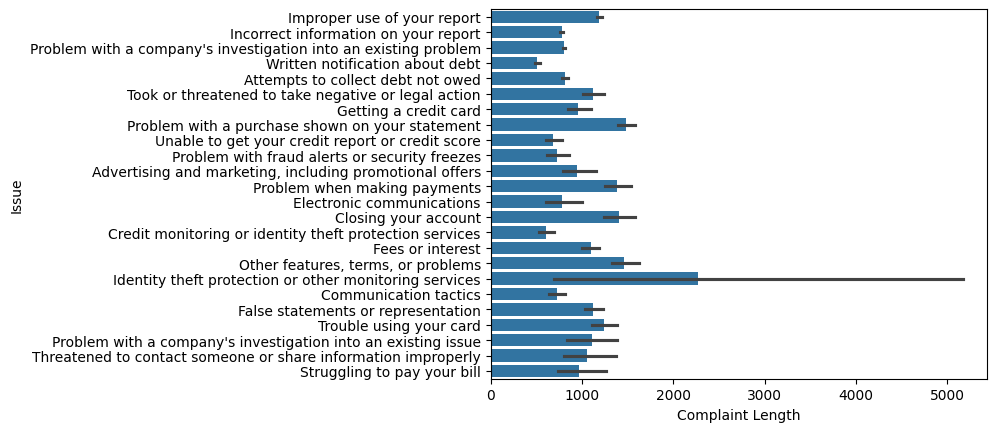

In [7]:
sns.barplot(x='Complaint Length', y='Issue', data=data)

**3. Text Preprocessing**

View missing values

In [8]:
for column in data.columns:
  print(column, data[column].isna().sum())

Date received 0
Product 0
Sub-product 0
Issue 0
Sub-issue 311
Consumer complaint narrative 0
Company public response 28645
Company 0
State 267
ZIP code 0
Tags 75541
Consumer consent provided? 0
Submitted via 0
Date sent to company 0
Company response to consumer 1
Timely response? 0
Consumer disputed? 79973
Complaint ID 0
Complaint Length 0


Drop significant missing values

In [9]:
colsToDrop = ['Tags', 'Company public response', 'Consumer disputed?']
data = data.drop(labels=colsToDrop, axis=1)
data.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company,State,ZIP code,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Complaint ID,Complaint Length
0,4/27/2024,Credit reporting or other personal consumer re...,Credit reporting,Improper use of your report,Credit inquiries on your report that you don't...,I am requesting the removal of fraudulent inqu...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",PA,19119,Consent provided,Web,4/27/2024,Closed with explanation,Yes,8875532,541
1,3/26/2024,Credit reporting or other personal consumer re...,Credit reporting,Incorrect information on your report,Information belongs to someone else,I am writing to delete the following informati...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",TX,75052,Consent provided,Web,3/26/2024,Closed with non-monetary relief,Yes,8629551,437
2,3/26/2024,Credit reporting or other personal consumer re...,Credit reporting,Problem with a company's investigation into an...,Investigation took more than 30 days,I am disappointed to have received a credit re...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",NY,11364,Consent provided,Web,3/26/2024,Closed with non-monetary relief,Yes,8630686,1837
3,3/26/2024,Credit reporting or other personal consumer re...,Credit reporting,Problem with a company's investigation into an...,Their investigation did not fix an error on yo...,I have received my credit report which suggest...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",NJ,07201,Consent provided,Web,3/26/2024,Closed with non-monetary relief,Yes,8626965,1594
4,3/26/2024,Credit reporting or other personal consumer re...,Credit reporting,Improper use of your report,Reporting company used your report improperly,In accordance with the Fair Credit Reporting a...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",AZ,85031,Consent provided,Web,3/26/2024,Closed with non-monetary relief,Yes,8631352,902


Convert most common data type found to default data type per column

In [10]:
def convertDtype(series):
  counts = series.apply(type).value_counts()
  return counts.idxmax()

mostCommon = {col: convertDtype(data[col]) for col in data.columns}

for col, dtype in mostCommon.items():
    data[col] = data[col].astype(dtype)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79973 entries, 0 to 79972
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   Date received                 79973 non-null  object
 1   Product                       79973 non-null  object
 2   Sub-product                   79973 non-null  object
 3   Issue                         79973 non-null  object
 4   Sub-issue                     79973 non-null  object
 5   Consumer complaint narrative  79973 non-null  object
 6   Company                       79973 non-null  object
 7   State                         79973 non-null  object
 8   ZIP code                      79973 non-null  object
 9   Consumer consent provided?    79973 non-null  object
 10  Submitted via                 79973 non-null  object
 11  Date sent to company          79973 non-null  object
 12  Company response to consumer  79973 non-null  object
 13  Timely response?

Tokenize

In [11]:
import re
stop_words = set(stopwords.words("english"))
stemmer = SnowballStemmer("english")

def tokenizeAndClean(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = word_tokenize(text)
    tokens = [t for t in tokens if t not in stop_words]
    return tokens

data["tokens"] = data["Consumer complaint narrative"].apply(tokenizeAndClean)


In [12]:
vectorizer = CountVectorizer(tokenizer=tokenizeAndClean, preprocessor=None)
dfm = vectorizer.fit_transform(data["Consumer complaint narrative"])

dfmDF = pd.DataFrame(dfm.toarray(), columns=vectorizer.get_feature_names_out())

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [20]:
dfmDF['tokens'] = data['tokens']

In [21]:
dfmDF['tokens'].head()

0    [requesting, removal, fraudulent, inquiries, c...
1    [writing, delete, following, information, file...
2    [disappointed, received, credit, report, conta...
3    [received, credit, report, suggests, may, owed...
4    [accordance, fair, credit, reporting, act, lis...
Name: tokens, dtype: object

**4. Descriptive Analysis**

Text length statistics

In [22]:
from statistics import mean, median, mode, stdev

dfmDF['token_lengths'] = dfmDF['tokens'].apply(len)
lengths = dfmDF['token_lengths'].tolist()

mean_length = mean(lengths)
median_length = median(lengths)
mode_length = mode(lengths)
stdev_length = stdev(lengths)
range_length = max(lengths) - min(lengths)

print(f"Mean length: {mean_length}")
print(f"Median length: {median_length}")
print(f"Mode length: {mode_length}")
print(f"Standard deviation: {stdev_length}")
print(f"Range: {range_length}")

Mean length: 82.48602653395521
Median length: 53
Mode length: 75
Standard deviation: 124.04033657329849
Range: 3338


Histogram of word lengths

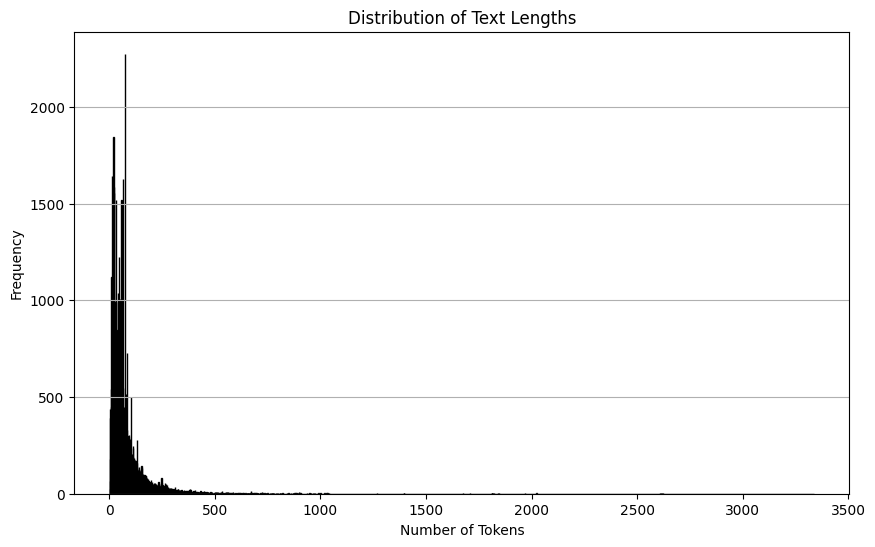

In [24]:
lengths = dfmDF['token_lengths'].tolist()

plt.figure(figsize=(10, 6))
plt.hist(lengths, bins=range(min(lengths), max(lengths) + 1), edgecolor='black')
plt.title('Distribution of Text Lengths')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.grid(axis='y')
plt.show()

Word Cloud

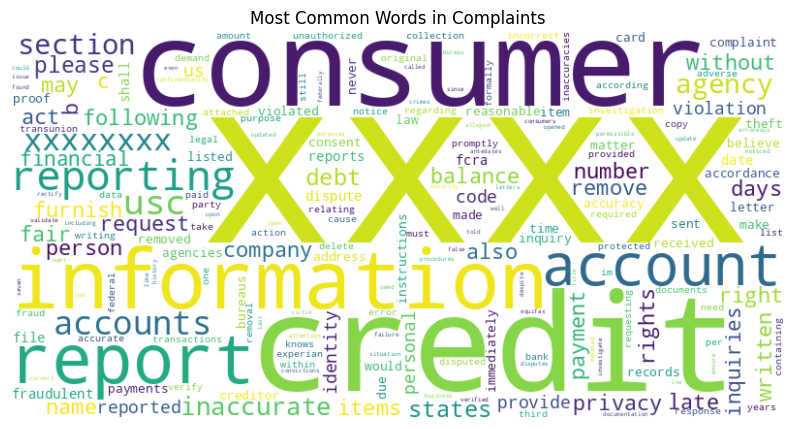

In [25]:
from collections import Counter
all_tokens = [token for sublist in dfmDF['tokens'] for token in sublist]

word_freq = Counter(all_tokens)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Words in Complaints')
plt.show()

**5. Sentiment Analysis**


In [17]:
from textblob import TextBlob

Assign polarity score

In [32]:
def get_sentiment(text):
    return TextBlob(str(text)).sentiment.polarity

dfmDF['polarity'] = dfmDF['tokens'].apply(get_sentiment)


In [37]:
print(f"Mean polarity: {dfmDF['polarity'].mean()}")
print(f"Median polarity: {dfmDF['polarity'].median()}")
print(f"Mode polarity: {dfmDF['polarity'].mode()[0]}")

Mean polarity: 0.04024235126232833
Median polarity: 0.0
Mode polarity: 0.0


Histogram of polarity scores

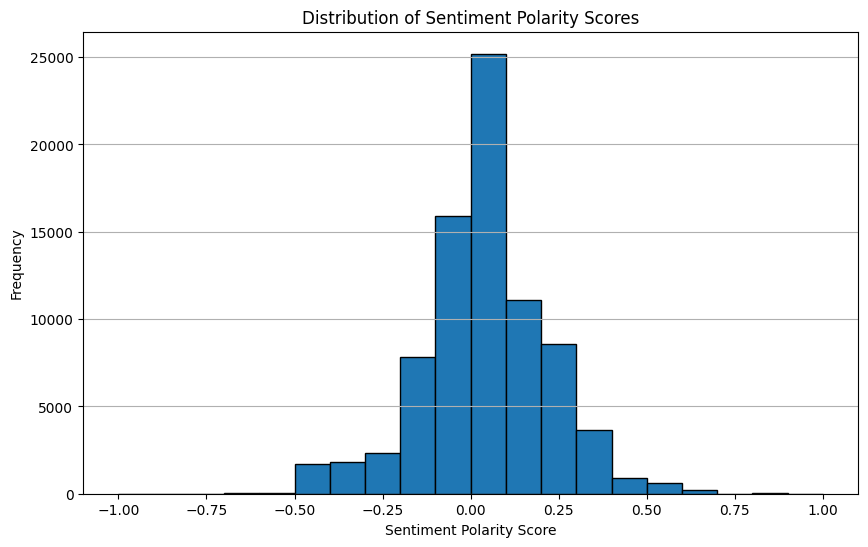

In [33]:
plt.figure(figsize=(10, 6))
plt.hist(dfmDF['polarity'], bins=20, edgecolor='black')
plt.title('Distribution of Sentiment Polarity Scores')
plt.xlabel('Sentiment Polarity Score')
plt.ylabel('Frequency')
plt.grid(axis='y')
plt.show()

Distribution of polarity scores

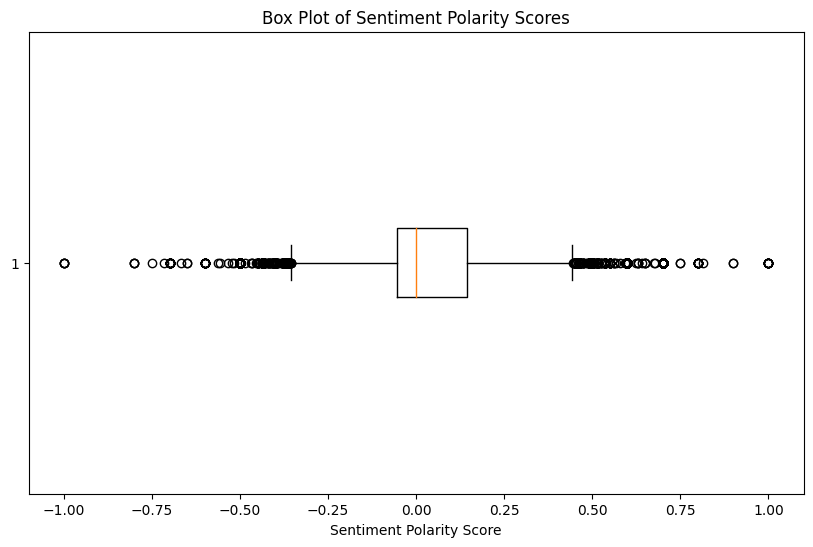

In [34]:
plt.figure(figsize=(10, 6))
plt.boxplot(dfmDF['polarity'], vert=False)
plt.title('Box Plot of Sentiment Polarity Scores')
plt.xlabel('Sentiment Polarity Score')
plt.show()

**6. Discussion and Conclusion**

This report analyzes the consumer financial protection bureau's complaints from consumers.  The three product categories included in the dataset were credit reports/personal consumer reports, debt collections, and credit cards.  Among the three products, most of the complaints included inaccurate data, improper use of data, and the methods used to obtain personal data.  The complaints seem to conclude that the bureau should refine operational processes and methods used for gathering and using consumer data.  

The polarity score seems to be distributed evenly. Based on the mean, median, mode, and visualizations of distrubution, the polarity score is quite difficult to draw insights and conclusions from.  

The word cloud visualizes words like privacy, inaccurate, fraudulent, credit, and violated.  These words found in the consumer complaints would support that consumers are unhappy with the quality of the data.  

Recommendations

I would provide two recommendations to the consumer financial protection bureau based off of the consumer complaints:
1. Review the methods used for collecting consumer data to ensure collection of data is ethical, legal, and valuable.  
2. Incorporate regular analysis of data to ensure accuracy and integrity of the data.  

Both a review of methods used for data collection and regular analysis of the data would be beneficial.  These actions would improve the accuracy and integrity of the data, increasing the quality of the product offerings.  With an increase in quality of the products, the consumer experience should improve, resulting in a decrease in consumer complaints.